# **Regresja wieloraka**

## Wczytywanie danych symulacji

In [13]:
import pandas as pd

df = pd.read_csv("symulacja_banku.csv")  # lub symulacja_banku_godziny.csv, zależnie od pliku
df['Dzien'] = df['Dzien'].astype(int)
dzien_encoded = pd.get_dummies(df['Dzien'], prefix='Dzien')
df_encoded = pd.concat([df, dzien_encoded], axis=1)

display(df_encoded)

,ID,Czas_przyjscia,Dlugosc kolejki w momencie przyjscia,Czas_rozpoczecia_obslugi,Czas_zakonczenia_obslugi,Czas_oczekiwania,Dzien,Stanowisko,Dzien_1,Dzien_2,Dzien_3,Dzien_4,Dzien_5
0,1001,0,0,0,8,0,1,1,True,False,False,False,False
1,1002,2,0,2,20,0,1,2,True,False,False,False,False
2,1003,3,0,3,5,0,1,3,True,False,False,False,False
3,1004,6,0,6,12,0,1,3,True,False,False,False,False
4,1005,17,0,17,23,0,1,1,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
957,5186,465,1,465,467,0,5,2,False,False,False,False,True
958,5187,465,0,465,471,0,5,3,False,False,False,False,True
959,5188,468,0,468,475,0,5,1,False,False,False,False,True
960,5189,471,0,471,483,0,5,2,False,False,False,False,True


In [14]:
def prepare_data(df):
    X = []
    y = []

    for _, row in df.iterrows():
        features = [
            1.0,  # bias
            float(row['Czas_przyjscia']),
            float(row['Dlugosc kolejki w momencie przyjscia']),
        ]
        # Tylko 4 kolumny zamiast 5
        for i in range(1, 5):  # Dzien_1 do Dzien_4
            features.append(int(row.get(f'Dzien_{i}', 0)))

        X.append(features)
        y.append([float(row['Czas_oczekiwania'])])

    return X, y


In [15]:
import numpy as np

def transpose(m):
    return list(map(list, zip(*m)))

def matmul(A, B):
    return [[sum(a * b for a, b in zip(row, col)) for col in zip(*B)] for row in A]

def inverse(matrix):
    return np.linalg.inv(np.array(matrix)).tolist()

def regression_beta(X, y):
    Xt = transpose(X)
    XtX = matmul(Xt, X)
    XtX_inv = inverse(XtX)
    XtY = matmul(Xt, y)
    return matmul(XtX_inv, XtY)

def predict(X, beta):
    return [sum(xi * bi[0] for xi, bi in zip(row, beta)) for row in X]

def r_squared(y_true, y_pred):
    mean_y = sum(y_true) / len(y_true)
    ss_tot = sum((yi - mean_y) ** 2 for yi in y_true)
    ss_res = sum((yi - ypi) ** 2 for yi, ypi in zip(y_true, y_pred))
    return 1 - ss_res / ss_tot




In [16]:
X, y = prepare_data(df_encoded)

beta = regression_beta(X, y)
y_hat = predict(X, beta)
r2 = r_squared([val[0] for val in y], y_hat)

print("Współczynniki beta:")
for i, b in enumerate(beta):
    print(f"b{i} = {b[0]}")

print(f"\nR² dopasowania modelu: {r2}")


Współczynniki beta:
b0 = -2.448387217563134
b1 = 0.012526067507090202
b2 = 2.1989904846426307
b3 = -0.14591495651727726
b4 = 0.05189930749306271
b5 = 4.087509657621805
b6 = -0.23763525537059138

R² dopasowania modelu: 0.8749074119924809


## **Współczynniki beta**

**b0**​	- wyraz wolny	-2.45 – wartość bazowa (czas oczekiwania), gdy wszystkie inne zmienne są zerowe. <br>
 Tutaj ma mały sens praktyczny, bo 0 minut przyjścia i 0 długości kolejki są rzadkie, a dodatkowo to tylko punkt odniesienia.

**b1**​	- Czas przyjścia	0.0125 – każda dodatkowa minuta przyjścia zwiększa czas oczekiwania o ok. 0.013 minuty, czyli 0.75 sekundy. Bardzo mały wpływ.

**b2**​	- Długość kolejki	2.20 – każda dodatkowa osoba w kolejce oznacza średnio 2.2 minuty więcej oczekiwania. To istotny współczynnik.

**b3​**	- Dzień 1	-0.15 – w porównaniu do dnia 5, dzień 1 daje nieco mniejsze oczekiwanie.

**b4**​	- Dzień 2	+0.05 – znikomy wzrost względem dnia 5.

**b5**​	- Dzień 3	+4.09 – duży wzrost oczekiwania względem dnia 5 – średnio o ponad 4 minuty.

**b6**​	- Dzień 4	-0.24 – dzień 4 jest trochę bardziej "luźny" niż dzień 5.

**Co z tego wynika?**

* Największy wpływ ma długość kolejki.
* Dzień 3 znacznie zwiększa czas oczekiwania – być może to dzień z największym ruchem.
* Pozostałe dni nie różnią się drastycznie od dnia 5 (referencyjnego).
* Czas przyjścia ma znikomy wpływ – system obsługuje klientów według kolejki, nie czasu przyjścia.

## **R²**

**R² = 0.875** → model dobrze dopasowany do danych.

Mówiąc inaczej: 87,5% różnic w czasie oczekiwania da się wyjaśnić przez zmienne wejściowe (np. długość kolejki, dzień, stanowisko itd.).

Pozostałe 12,5% to „szum”, czyli coś, czego model nie przewidział – np. losowe fluktuacje, czynniki nieuwzględnione w modelu.

RMSE (średni błąd kwadratowy): 5.88 min
Korelacja wieloraka  R: 0.935
Korelacja cząstkowa (czas oczekiwania vs długość kolejki (reszta)): 0.856


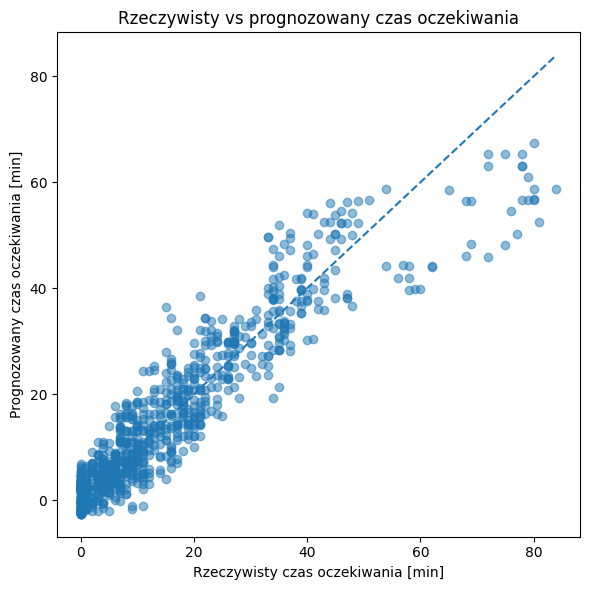

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

# RMSE (średni błąd prognozy) / mały błąd 1 to 1, duży błąd 10 to 100, co zwiększa odchylenie
rmse = math.sqrt(sum((yi[0] - ypi) ** 2 for yi, ypi in zip(y, y_hat)) / len(y))
print(f"RMSE (średni błąd kwadratowy): {rmse:.2f} min")

# Korelacja wieloraka R (pierwiastek z R²)
R_multiple = math.sqrt(r2)
print(f"Korelacja wieloraka  R: {R_multiple:.3f}")

# Korelacja cząstkowa (wycinamy wpływ czasu przyjścia i dni tygodnia)
# macierz kontrolna = Czas_przyjscia + Dzien 
X_controls = [row[:2] + row[3:] for row in X]

# reszty dla czasu oczekiwania
beta_wait = regression_beta(X_controls, y)
res_wait  = [yi[0] - yp for yi, yp in zip(y, predict(X_controls, beta_wait))]

# reszty dla długości kolejki
queue_vec = [row[2] for row in X]
beta_qlen = regression_beta(X_controls, [[q] for q in queue_vec])
res_qlen  = [q - qp for q, qp in zip(queue_vec, predict(X_controls, beta_qlen))]

# klasyczna korelacja Pearsona reszt
def corr(a, b):
    ma, mb = np.mean(a), np.mean(b)
    num = sum((ai - ma) * (bi - mb) for ai, bi in zip(a, b))
    den = math.sqrt(sum((ai - ma) ** 2 for ai in a) * sum((bi - mb) ** 2 for bi in b))
    return num / den

r_partial = corr(res_wait, res_qlen)
print(f"Korelacja cząstkowa (czas oczekiwania vs długość kolejki (reszta)): {r_partial:.3f}")

# Wykres rzeczywistego vs prognozowanego czasu oczekiwania
plt.figure(figsize=(6, 6))
plt.scatter([v[0] for v in y], y_hat, alpha=0.5)
plt.xlabel("Rzeczywisty czas oczekiwania [min]")
plt.ylabel("Prognozowany czas oczekiwania [min]")
plt.title("Rzeczywisty vs prognozowany czas oczekiwania")
m = max(max(y_hat), max(v[0] for v in y))
plt.plot([0, m], [0, m], "--")
plt.tight_layout()
plt.show()


## **RMSE i korelacje**

| Miara | Wartość | Co oznacza? |
|-------|---------|-------------|
| RMSE | 5,9 min | Średnio o tyle minut mylimy się w prognozie – błąd rzędu kilku minut przy kolejkach kilkunastominutowych jest akceptowalny. |
| R (korelacja wieloraka) | 0,94 | Wszystkie zmienne razem (czas przyjścia, długość kolejki, dzień) mają bardzo silny związek z czasem oczekiwania. |
| r cząstkowe (długość kolejki vs czas oczekiwania (reszta)) | 0,86 | Nawet po wycięciu wpływu dnia i godziny przyjścia, sama liczba osób w kolejce wciąż mocno wydłuża czekanie. |

* Model trafia w czasy całkiem dobrze (mały RMSE, wysokie R).  
* Kolejka pozostaje głównym winowajcą, nawet gdy inne czynniki są pod kontrolą.


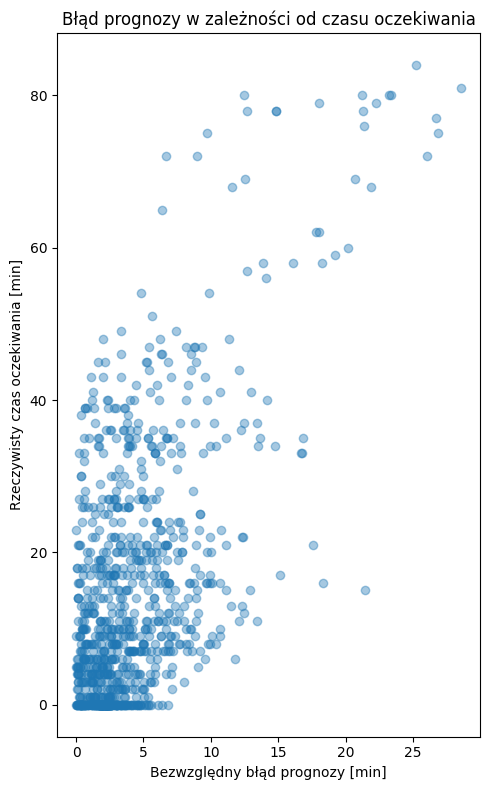

Błąd, a czas oczekiwania: 0.62


In [18]:
# Czy dłuższe kolejki dają większy błąd prognozy?

import math
import numpy as np
import matplotlib.pyplot as plt

residuals       = [yi[0] - ypi for yi, ypi in zip(y, y_hat)] # reszty (y - y_hat) z poprzedniej analizy
abs_residuals   = [abs(r) for r in residuals] # bezwzględny błąd
wait_times      = [yi[0] for yi in y] # rzeczywisty czas

# funkcja korelacji Pearsona
def corr(a, b):
    ma, mb = np.mean(a), np.mean(b)
    num = sum((ai - ma) * (bi - mb) for ai, bi in zip(a, b))
    den = math.sqrt(sum((ai - ma) ** 2 for ai in a) * sum((bi - mb) ** 2 for bi in b))
    return num / den

corr_err = corr(abs_residuals, wait_times)

plt.figure(figsize=(5, 8))
plt.scatter(abs_residuals, wait_times, alpha=0.4)
plt.xlabel("Bezwzględny błąd prognozy [min]")
plt.ylabel("Rzeczywisty czas oczekiwania [min]")
plt.title("Błąd prognozy w zależności od czasu oczekiwania")
plt.tight_layout()
plt.show()

print(f"Błąd, a czas oczekiwania: {corr_err:.2f}")


### Błąd prognozy a długość oczekiwania

#### Wnioski z wykresu i korelacji: ####

* **Pionowa oś:** rzeczywisty czas oczekiwania
* **Pozioma oś:** błąd naszego modelu (o ile minut się pomyliliśmy)
* **Interpretacja korelacji:**  
  * **Błąd jest większy od 0,3:** im dłuższe czekanie, tym błąd naszej prognozy rośnie
  * Jeśli błąd byłby między –0,3 a 0,3: punkty byłyby rozrzucone losowo i model myliłby się podobnie
  * Jeśli błąd byłby poniżej –0,3: byłby to specyficzy przypadek, gdzie przy długim czekaniu model radziłby sobie lepiej